<h1>Preprocessing </h1>

In [2]:
import tensorflow as tf
import cv2
import numpy as np
import os
import sys # for debugging 

In [3]:

# # This function preprocesses the image by reading in the image apply grayscale make all the sizes the same and 
# def preprocess_image(file_path, img_size):
#     img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE) # Grayscale will even the playing field if we start getting different types of images. If the images color is a factor we can take out grayscale
#     img = cv2.resize(img, img_size)
#     img = img.astype('float')/255.0 # Make the pixels become float and normalize to 0-1 for normalization
#     return img







# This function preprocesses the image by reading in the image apply grayscale make all the sizes the same and 
def preprocess_image(file_path, img_size):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE) # Grayscale will even the playing field if we start getting different types of images. If the images color is a factor we can take out grayscale
    
    # Thresholding to remove black background
    _, binary_image = cv2.threshold(img, 10, 255, cv2.THRESH_BINARY)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)
    largest_component_label = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
    brain_mask = (labels == largest_component_label).astype(np.uint8) * 255
    x, y, w, h = cv2.boundingRect(brain_mask)
    img = img[y:y+h, x:x+w]
    
    img = cv2.resize(img, img_size)
    img = img.astype('float')/255.0 # Make the pixels become float and normalize to 0-1 for normalization
    return img


target_size =(224, 224)

# This function will pull from the directory and all subdirectory for the image and give it a label to the directory it is in
def load_images_from_directory(directory):
    images = []
    labels = []
    # Iterates through all subdirectories
    for subdir in os.listdir(directory):
        label = subdir #Make the subdirectory name be a label
        subdir_path = os.path.join(directory, subdir)

        # Checks if the object it is looking at is a directory and if it is go into the directory and get all the files and preprocess them
        if os.path.isdir(subdir_path):
            for image in os.listdir(subdir_path):
                file_path = os.path.join(subdir_path, image)

                image = preprocess_image(file_path, target_size)

                # Append to the arrays after preprocessing
                images.append(image)
                labels.append(label)

    return np.array(images), np.array(labels)




In [4]:


# Define the directory paths for the training and test datasets
train_dir = "./Alzheimer_s Dataset/train"
test_dir = "./Alzheimer_s Dataset/test"
single_test_dir = "./Alzheimer_s Dataset/single_test"

# Load images and labels from the training directory
alz_images_train, alz_labels_train = load_images_from_directory(train_dir)

# Load images and labels from the test directory
alz_images_test, alz_labels_test = load_images_from_directory(test_dir)

alz_single_images_test, alz_single_labels_test = load_images_from_directory(single_test_dir)

# Print information about the training dataset
print("Train")
print('Image shape:', alz_images_train.shape)
print('Labels shape:', alz_labels_train.shape)

# Print information about the test dataset
print("\nTest")
print('Image shape:', alz_images_test.shape)
print('Labels shape:', alz_labels_test.shape)


print("\nSingle Test")
print('Image shape:', alz_single_images_test.shape)
print('Labels shape:', alz_single_labels_test.shape)


np.set_printoptions(threshold=sys.maxsize) # for debugging

print('Image train:', alz_single_images_test) # for debugging

# The output of the shape follows this
#  (X, X1, X2)
# X is the number of pictures in the array   
# X1 is the number of rows for a single picture (should be 224 since that is the scale)
# X2 is the number of columns in each picture  (should be 224 since that is the scale)
#  *Scale can be change to 207 since that is how the data is processed. 
# 
# When pull out the full array, you see alot of 0 at the start and end and that is because of the black around the brain
# 


Train
Image shape: (5121, 224, 224)
Labels shape: (5121,)

Test
Image shape: (1279, 224, 224)
Labels shape: (1279,)

Single Test
Image shape: (1, 224, 224)
Labels shape: (1,)
Image train: [[[0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.00392157 0.01960784 0.00784314 0.00392157
   0.01568627 0.01176471 0.         0.         0.01176471 0.03921569
   0.02352941 0.         0.         0.         0.         0.0039

<h1> Aaron's Algorithm </h1>
CNN GCNN or similar neural networks that can be adjusted in between each other

In [4]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

alz_labels_train_encoded = label_encoder.fit_transform(alz_labels_train)
alz_labels_test_encoded = label_encoder.fit_transform(alz_labels_test)

num_classes = len(label_encoder.classes_)

alz_labels_train_onehot = tf.keras.utils.to_categorical(alz_labels_train_encoded, num_classes)
alz_labels_test_onehot = tf.keras.utils.to_categorical(alz_labels_test_encoded, num_classes)

#np.set_printoptions(threshold=sys.maxsize) # for debugging
#print(alz_labels_train_onehot)

print("Training labels shape (one-hot encoded):", alz_labels_train_onehot.shape)
print("Testing labels shape (one-hot encoded):", alz_labels_test_onehot.shape)

# print('Image train:', alz_images_train) # for debugging


# 0 = MildDemented
# 1 = ModerateDemented
# 2 = NonDemented
# 3 = VeryMildDemented

Training labels shape (one-hot encoded): (5121, 4)
Testing labels shape (one-hot encoded): (1279, 4)


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

img_height = target_size[1]
img_width = target_size[0]
num_channels = 1


model3 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, num_channels)), #all factors can be adjusted
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),

    Dense(64, activation='relu'),
    Dropout(0.7),
    Dense(num_classes, activation='softmax')
])

model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 186624)            0         
                                                                 
 dense_8 (Dense)             (None, 64)               

In [10]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model3.fit(alz_images_train, alz_labels_train_onehot, epochs=10, batch_size=32, validation_data=(alz_images_test, alz_labels_test_onehot))




Epoch 1/10
161/161 [==============================] - 55s 336ms/step - loss: 1.1589 - accuracy: 0.4733 - val_loss: 1.0713 - val_accuracy: 0.3534
Epoch 2/10
161/161 [==============================] - 55s 340ms/step - loss: 1.0159 - accuracy: 0.5026 - val_loss: 1.0826 - val_accuracy: 0.5020
Epoch 3/10
161/161 [==============================] - 55s 341ms/step - loss: 0.9593 - accuracy: 0.5247 - val_loss: 1.2423 - val_accuracy: 0.5020
Epoch 4/10
161/161 [==============================] - 54s 339ms/step - loss: 0.8850 - accuracy: 0.5688 - val_loss: 1.0281 - val_accuracy: 0.5465
Epoch 5/10
161/161 [==============================] - 52s 323ms/step - loss: 0.8115 - accuracy: 0.6009 - val_loss: 0.9684 - val_accuracy: 0.5504
Epoch 6/10
161/161 [==============================] - 54s 333ms/step - loss: 0.7391 - accuracy: 0.6317 - val_loss: 1.1631 - val_accuracy: 0.5590
Epoch 7/10
161/161 [==============================] - 53s 329ms/step - loss: 0.6418 - accuracy: 0.6917 - val_loss: 1.1526 - val_ac

In [17]:
img_height = target_size[1]
img_width = target_size[0]
num_channels = 1


model4 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, num_channels)), #all factors can be adjusted
    MaxPooling2D((2,2)),
    # Conv2D(64, (3,3), activation='relu'),
    # MaxPooling2D((2,2)),

    Flatten(),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

#model4.summary()


from tensorflow.keras.optimizers import SGD
#optimizer = RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07) 
optimizer = SGD(learning_rate=0.01, momentum=0.9)


#model4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model4.fit(alz_images_train, alz_labels_train_onehot, epochs=10, batch_size=32, validation_data=(alz_images_test, alz_labels_test_onehot))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 394272)            0         
                                                                 
 dense_10 (Dense)            (None, 128)               50466944  
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 4)                 516       
                                                      

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Define model architecture with reduced complexity and added dropout
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, num_channels)),
    AveragePooling2D((2,2)),
    #MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    #MaxPooling2D((2,2)),
    AveragePooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model with Adam optimizer and categorical crossentropy loss
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(alz_images_train, alz_labels_train_onehot, epochs=15, batch_size=32,
                     validation_data=(alz_images_test, alz_labels_test_onehot), callbacks=[early_stopping])
#history = model.fit(alz_images_train, alz_labels_train_onehot, epochs=15, batch_size=32,
#                    validation_data=(alz_images_test, alz_labels_test_onehot))


Epoch 1/15
161/161 [==============================] - 56s 342ms/step - loss: 1.1871 - accuracy: 0.4876 - val_loss: 1.1231 - val_accuracy: 0.5004
Epoch 2/15
161/161 [==============================] - 54s 337ms/step - loss: 0.9733 - accuracy: 0.5388 - val_loss: 1.2389 - val_accuracy: 0.5152
Epoch 3/15
161/161 [==============================] - 54s 337ms/step - loss: 0.9281 - accuracy: 0.5561 - val_loss: 1.4916 - val_accuracy: 0.5035
Epoch 4/15
161/161 [==============================] - 54s 335ms/step - loss: 0.9203 - accuracy: 0.5649 - val_loss: 1.1536 - val_accuracy: 0.5082


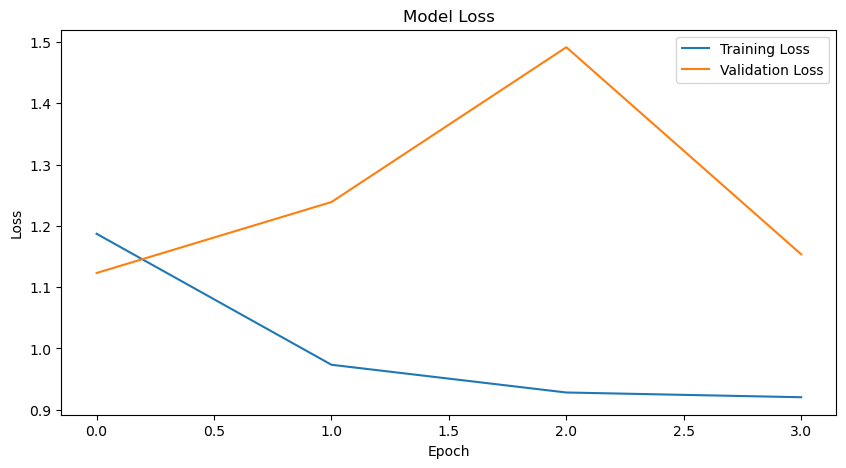

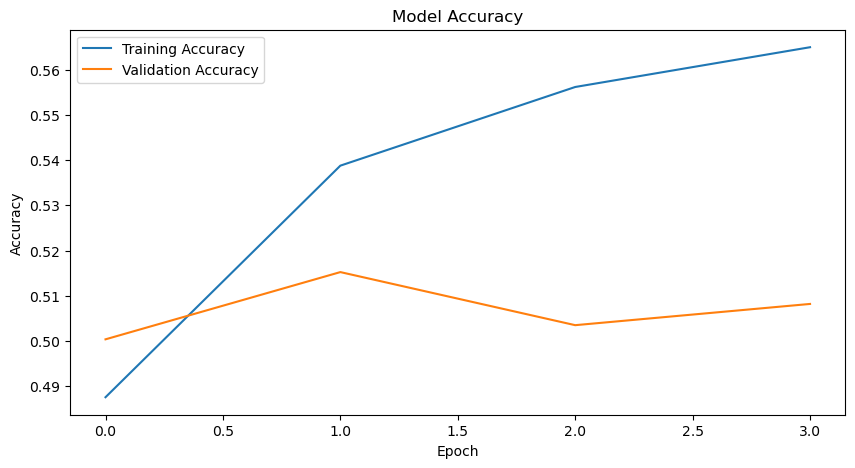

In [29]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Make predictions on the validation set
predictions = model.predict(alz_images_test)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Compare predicted labels with true labels
misclassified_indices = np.where(predicted_labels != np.argmax(alz_labels_test_onehot, axis=1))[0]

# Extract and analyze misclassified samples
misclassified_images = alz_images_test[misclassified_indices]
misclassified_true_labels = np.argmax(alz_labels_test_onehot[misclassified_indices], axis=1)
misclassified_predicted_labels = predicted_labels[misclassified_indices]

# Visualize misclassified samples
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(min(len(misclassified_indices), 25)):
    plt.subplot(5, 5, i + 1)
    plt.imshow(misclassified_images[i], cmap='gray')
    plt.title(f'True: {misclassified_true_labels[i]}, Predicted: {misclassified_predicted_labels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


<h1>Jay's Algorthm</h1>
SVM and KNN (K-Nearest Neighbors)

<h1>Geoffrey's Algorithm</h1>
Random Forest and RNN

Notes below

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, img_channels)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Print model summary
model.summary()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Initialize the CNN model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, num_channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Add flattening layer
model.add(Flatten())

# Add fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax activation for multi-class classification

# Print model summary
model.summary()


This for DENSE (fully connected layer)

Tunable Hyperparameters: Instead of choosing a fixed number of units, you can treat the number of units in dense layers as a hyperparameter to be tuned during model training using techniques like grid search or random search. This approach allows for more flexibility in optimizing the model's architecture for specific datasets and tasks.

In [ ]:
#visualization and accuracy code below

# test_loss, test_accuracy = model1.evaluate(alz_images_test, alz_labels_test_onehot)
# print('Test Loss:', test_loss)
# print('Test Accuracy:', test_accuracy)

# import matplotlib.pyplot as plt

# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label='val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
# plt.show()